<a href="https://colab.research.google.com/github/PacktPublishing/Hands-On-Computer-Vision-with-PyTorch/blob/master/Chapter09/Instance_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Instance Segmentation with Mask R-CNN
The [Mask R-CNN](https://arxiv.org/pdf/1703.06870.pdf) architecture is an extension of the Faster R-CNN network with the following modifications:
- The RoI Pooling layer has been replaced with the RoI Align layer.
- A mask head has been included to predict a mask of objects in addition to the head, which already predicts the classes of objects and bounding box correction in the final layer.
- A fully convolutional network (FCN) is leveraged for mask prediction.


The following figure describe the architecture: 
![mask_rcnn](mask_rcnn_1.png)

note that we are fetching the class and bounding box information from one layer and the mask information from another layer.

A more detailed illustration is as follows:
![mask_rcnn2](mask_rcnn_2.png)

## ROI Align
With Faster R-CNN, we learned about RoI Pooling. One of the drawbacks of RoI Pooling is that we are likely to lose certain information when we are performing the RoI pooling operation. This is because we are likely to have an even representation of content across all the areas of an image before pooling.   

<font color='red'> Not Clear! </font>

Let's see an example for the problem. consider the following image:
![mask_rcnn3](mask_rcnn_3.png)

In the preceding image, the region proposal is 5 x 7 in shape and we have to convert it into a 2 x 2 shape. While converting it into a 2 x 2 shape (a phenomenon called quantization), one part of the region has less representation compared to other parts of the region. This results in information loss since certain parts of the region have more weight than others. RoI Align comes to the rescue to address such a scenario

To understand how RoI Align works, let's go through a simple example. Here, we are trying to convert the following region (which is represented in dashed lines) into a 2 x 2 shape:
![mask_rcnn4](mask_rcnn_4.png)

Note that the region (in dashed lines) is not equally spread across all the cells in the feature map. (recall that the region is given in pixel resolution whereas the feature map is already at reduced resolution)

We must perform the following steps to get a reasonable representation of the region in a 2 x 2 shape:

1. Divide the region to 2x2 shape:
    ![mask_rcnn5](mask_rcnn_5.png)
2. Define four points that are equally spaced within each of the 2 x 2 cells:
    ![mask_rcnn6](mask_rcnn_6.png)
    the distance between two consecutive points is 0.75.
3. Calculate the weighted average value of each point based on its distance to the nearest known value:
    ![mask_rcnn7](mask_rcnn_7.png)
4. Repeat for all four points in a cell:
    ![mask_rcnn8](mask_rcnn_8.png)
5. perform average pooling across all four points within a cell:
    ![mask_rcnn9](mask_rcnn_9.png)

By implementing the preceding steps, we don't lose out on information when performing RoI Align; that is, when we place all the regions inside the same shape



## Mask Head
Now, we want to obtain the segmentation (mask) output, given a standard shaped RoI Align output, for every region proposal.
Typically, in the case of object detection, we would pass the RoI Align through a flattened layer in order to predict the object's class and bounding box offset. However, in the case of image segmentation, we predict the pixels within a bounding box that contains the object. Hence, we now have a third output (apart from class and bounding box offset), which is the predicted mask within the region of interest.
Here, we are predicting the mask, which is an image overlay on top of the original image. Given that we are predicting an image, instead of flattening the RoI Align's output, we'll connect it to another convolution layer to get another image-like structure (width x height in dimension). Let's understand this phenomenon by taking a look at the following diagram:
![mask_rcnn10](mask_rcnn_10.png)

we have obtained an output of shape 7 x 7 x 2048 using the feature pyramid network (FPN), which now has 2 branches:
- The first branch returns the class of the object and the bounding box, post flattening the FPN output.
- The second branch performs convolution on top of the FPN's output to get a mask.

The ground truth corresponding to the 14 x 14 output is the resized image of the region proposals. The ground truth of the region proposal is of the shape 80 x 14 x 14 if there are 80 unique classes in the dataset. Each of the 80 x 14 x 14 pixels is a 1 or a 0, which indicates whether the pixel contains an object or not. Thus, we are performing binary cross-entropy loss minimization while predicting the class of a pixel.

Post model training, we are able to detect regions, get classes, get bounding box offsets, and get the mask corresponding to each region. When making an inference, we first detect the objects present in the image and make bounding box corrections. Then, we pass the offsetted region to the mask head to predict the mask that corresponds to different pixels in the region.

# implementation
The dataset we'll be using has been created from a subset of the [ADE20K](https://groups.csail.mit.edu/vision/datasets/ADE20K/) dataset. We will only use those images where we have masks for people.
we'll take the following steps:
1. Fetch the dataset and then create datasets and dataloaders from it.
2. Create a ground truth in a format needed for PyTorch's official implementation of Mask R-CNN.
3. Download the pre-trained Faster R-CNN model and attach a Mask R-CNN head to it.
4. Train the model with a PyTorch code snippet that has been standardized for training Mask R-CNN.
5. Infer on an image by performing non-max suppression first and then identifying the bounding box and the mask corresponding to the people in the image.

## fetch the dataset

In [ ]:
# !wget --quiet http://sceneparsing.csail.mit.edu/data/ChallengeData2017/images.tar
# !wget --quiet http://sceneparsing.csail.mit.edu/data/ChallengeData2017/annotations_instance.tar
# !tar -xf images.tar
# !tar -xf annotations_instance.tar
# !rm images.tar annotations_instance.tar
# # !pip install -qU torch_snippets
# !wget --quiet https://raw.githubusercontent.com/pytorch/vision/master/references/detection/engine.py
# !wget --quiet https://raw.githubusercontent.com/pytorch/vision/master/references/detection/utils.py
# !wget --quiet https://raw.githubusercontent.com/pytorch/vision/master/references/detection/transforms.py
# !wget --quiet https://raw.githubusercontent.com/pytorch/vision/master/references/detection/coco_eval.py
# !wget --quiet https://raw.githubusercontent.com/pytorch/vision/master/references/detection/coco_utils.py
# # !pip install -q -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

In [1]:
from torch_snippets import *

import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

from engine import train_one_epoch, evaluate
import utils
import transforms as T
# import torchvision.transforms as T
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Fetch images that contain masks of people
In this particular dataset, the ground truth instance annotations are provided in such a way that the Red channel in RGB corresponds to the class of object, while the Green channel corresponds to the instance number (in case there are multiple objects of the same class in the image – as in our example here). Furthermore, the Person class is encoded with a value of 4.

In [2]:
all_images = Glob('images/training')
all_annots = Glob('annotations_instance/training')

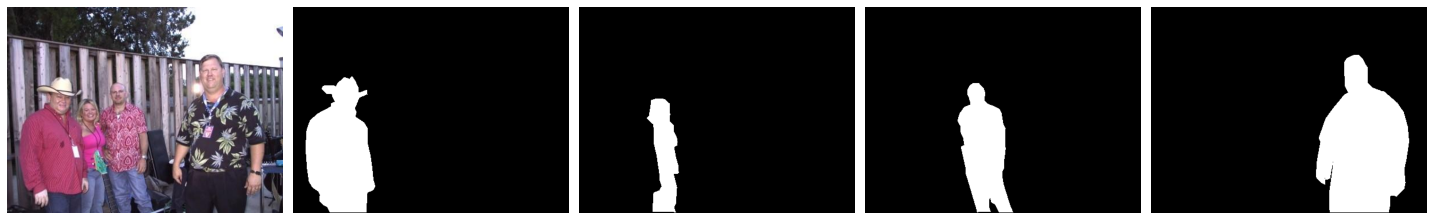

In [3]:
f = 'ADE_train_00014301'

im = read(find(f, all_images), 1)
an = read(find(f, all_annots), 1).transpose(2,0,1)
r,g,b = an
nzs = np.nonzero(r==4) # 4 stands for person
instances = np.unique(g[nzs])
masks = np.zeros((len(instances), *r.shape))
for ix,_id in enumerate(instances):
    masks[ix] = g==_id

subplots([im, *masks], sz=20)

In [ ]:
# debug 
find(f, all_images)
im1=Image.open(find(f, all_images))
type(im1)

In [4]:
# Loop through the annotations and store the files that contain at least one person:
annots = []
for ann in Tqdm(all_annots):
    _ann = read(ann, 1).transpose(2,0,1)
    r,g,b = _ann
    if 4 not in np.unique(r): continue
    annots.append(ann)

100%|███████████████████████████████████████████████████████████████████████████████████████████| 20210/20210 [01:13<00:00, 274.96it/s]


In [5]:
# Split the files into training and validation files
from sklearn.model_selection import train_test_split
_annots = stems(annots)
trn_items, val_items = train_test_split(_annots, random_state=2)

In [ ]:
dir(T)

In [6]:
def get_transform(train):
    transforms = []
    transforms.append(T.PILToTensor())      # note : was originally T.ToTensor although we dont have it in the module
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [7]:
class MasksDataset(Dataset):
    def __init__(self, items, transforms, N):
        self.items = items   # image names
        self.transforms = transforms
        self.N = N  # number of files to consider as input
    def get_mask(self, path):
        '''
        a method fetch a number of masks that's equivalent to the instances present in the image
        '''
        an = read(path, 1).transpose(2,0,1)
        r,g,b = an
        nzs = np.nonzero(r==4)  # people are class id 4
        instances = np.unique(g[nzs])
        masks = np.zeros((len(instances), *r.shape))
        for ix,_id in enumerate(instances):
            masks[ix] = g==_id
        return masks
    def __getitem__(self, ix):
        '''
        Each person (instance) is treated as a different object class; that is, each instance is a different class.
        the targets are returned as a dictionary of tensors.
        '''
        _id = self.items[ix]
        img_path = f'images/training/{_id}.jpg'
        mask_path = f'annotations_instance/training/{_id}.png'
        masks = self.get_mask(mask_path)
        obj_ids = np.arange(1, len(masks)+1)
        img = Image.open(img_path).convert("RGB")
        num_objs = len(obj_ids)
        # prepare the bounding box information
        boxes = []
        for i in range(num_objs):
            obj_pixels = np.where(masks[i])
            xmin = np.min(obj_pixels[1])
            xmax = np.max(obj_pixels[1])
            ymin = np.min(obj_pixels[0])
            ymax = np.max(obj_pixels[0])
            # we are adjusting for scenarios where there are dubious ground truths 
            # (the height or width of the Person class is less than 10 pixels) 
            # by adding 10 pixels to the minimums of the x and y coordinates of the bounding box
            if (((xmax-xmin)<=10) | (ymax-ymin)<=10):
                xmax = xmin+10
                ymax = ymin+10
            boxes.append([xmin, ymin, xmax, ymax])
        # convert all target values to tensor objects 
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)
        image_id = torch.tensor([ix])
        # and store the target values in a dictionary
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd
        if self.transforms is not None:
            img, target = self.transforms(img, target)
            img = (img/255.0).type(torch.FloatTensor)
        return img, target
    def __len__(self):
        return self.N
    def choose(self):
        return self[randint(len(self))]

Tensor	Shape: torch.Size([3, 340, 454])	Min: 0.000	Max: 1.000	Mean: 0.503	dtype: torch.float32
Dict Of 6 items
	BOXES:
	Tensor	Shape: torch.Size([1, 4])	Min: 158.000	Max: 326.000	Mean: 260.000	dtype: torch.float32
	LABELS:
	Tensor	Shape: torch.Size([1])	Min: 1.000	Max: 1.000	Mean: 1.000	dtype: torch.int64
	MASKS:
	Tensor	Shape: torch.Size([1, 340, 454])	Min: 0.000	Max: 1.000	Mean: 0.020	dtype: torch.uint8
	IMAGE_ID:
	Tensor	Shape: torch.Size([1])	Min: 0.000	Max: 0.000	Mean: 0.000	dtype: torch.int64
	AREA:
	Tensor	Shape: torch.Size([1])	Min: 5428.000	Max: 5428.000	Mean: 5428.000	dtype: torch.float32
... ... -4 more item(s)


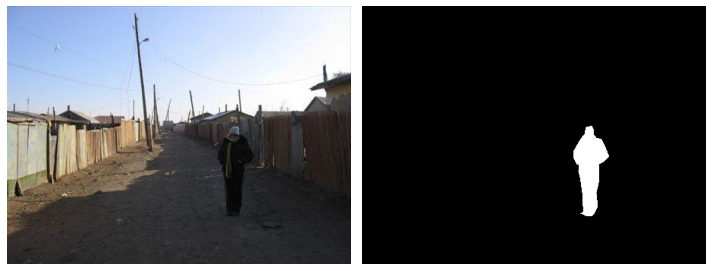

In [8]:
x = MasksDataset(trn_items, get_transform(train=True), N=100)
im,targ = x[0]
inspect(im,targ)
subplots([im, *targ['masks']], sz=10)

In [9]:
def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,num_classes)
    return model

In [10]:
model = get_model_instance_segmentation(2).to(device)
model

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [11]:
dataset = MasksDataset(trn_items, get_transform(train=True), N=3000)
dataset_test = MasksDataset(val_items, get_transform(train=False), N=800)

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=0,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=0,
    collate_fn=utils.collate_fn)

In [12]:
num_classes = 2
model = get_model_instance_segmentation(num_classes).to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)
# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                step_size=3,
                                                gamma=0.1)

In [ ]:
# batch = next(iter(data_loader))
# batch

In [13]:
num_epochs = 5

trn_history = []
for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    res = train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    trn_history.append(res)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    res = evaluate(model, data_loader_test, device=device)

/home/guy/anaconda3/envs/ptvit/lib/python3.8/site-packages/torch-1.10.1-py3.8-linux-x86_64.egg/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Epoch: [0]  [   0/1500]  eta: 0:12:50  lr: 0.000010  loss: 5.5650 (5.5650)  loss_classifier: 0.6553 (0.6553)  loss_box_reg: 0.1473 (0.1473)  loss_mask: 4.7529 (4.7529)  loss_objectness: 0.0089 (0.0089)  loss_rpn_box_reg: 0.0007 (0.0007)  time: 0.5135  data: 0.0328  max mem: 2305
Epoch: [0]  [  10/1500]  eta: 0:14:28  lr: 0.000060  loss: 4.4999 (4.6112)  loss_classifier: 0.5789 (0.5870)  loss_box_reg: 0.2904 (0.3136)  loss_mask: 3.8115 (3.6534)  loss_objectness: 0.0346 (0.0374)  loss_rpn_box_reg: 0.0099 (0.0197)  time: 0.5831  data: 0.0554  max mem: 3332
Epoch: [0]  [  20/1500]  eta: 0:13:53  lr: 0.000110  loss: 2.5256 (3.2431)  loss_classifier: 0.4803 (0.4827)  loss_box_reg: 0.2773 (0.2895)  loss_mask: 1.6852 (2.4208)  loss_objectness: 0.0211 (0.0301)  loss_rpn_box_reg: 0.0106 (0.0201)  time: 0.5660  data: 0.0430  max mem: 3556
Epoch: [0]  [  30/1500]  eta: 0:13:36  lr: 0.000160  loss: 1.4297 (2.5982)  loss_classifier: 0.2607 (0.3991)  loss_box_reg: 0.2398 (0.2682)  loss_mask: 0.8296 (

Epoch: [0]  [ 300/1500]  eta: 0:11:29  lr: 0.001508  loss: 0.6774 (0.9774)  loss_classifier: 0.1058 (0.1644)  loss_box_reg: 0.2220 (0.2519)  loss_mask: 0.3354 (0.5052)  loss_objectness: 0.0190 (0.0327)  loss_rpn_box_reg: 0.0158 (0.0232)  time: 0.6012  data: 0.0393  max mem: 4136
Epoch: [0]  [ 310/1500]  eta: 0:11:23  lr: 0.001558  loss: 0.6649 (0.9700)  loss_classifier: 0.0876 (0.1633)  loss_box_reg: 0.1522 (0.2513)  loss_mask: 0.3231 (0.4996)  loss_objectness: 0.0156 (0.0325)  loss_rpn_box_reg: 0.0141 (0.0233)  time: 0.5793  data: 0.0315  max mem: 4136
Epoch: [0]  [ 320/1500]  eta: 0:11:19  lr: 0.001608  loss: 0.6670 (0.9612)  loss_classifier: 0.0950 (0.1618)  loss_box_reg: 0.1909 (0.2495)  loss_mask: 0.3231 (0.4948)  loss_objectness: 0.0155 (0.0321)  loss_rpn_box_reg: 0.0158 (0.0231)  time: 0.5934  data: 0.0330  max mem: 4136
Epoch: [0]  [ 330/1500]  eta: 0:11:15  lr: 0.001658  loss: 0.7035 (0.9561)  loss_classifier: 0.1052 (0.1611)  loss_box_reg: 0.2247 (0.2499)  loss_mask: 0.3511 (

Epoch: [0]  [ 600/1500]  eta: 0:08:46  lr: 0.003007  loss: 0.5733 (0.8378)  loss_classifier: 0.0900 (0.1411)  loss_box_reg: 0.1475 (0.2216)  loss_mask: 0.3102 (0.4219)  loss_objectness: 0.0142 (0.0303)  loss_rpn_box_reg: 0.0128 (0.0229)  time: 0.5994  data: 0.0294  max mem: 4147
Epoch: [0]  [ 610/1500]  eta: 0:08:41  lr: 0.003057  loss: 0.6914 (0.8371)  loss_classifier: 0.1277 (0.1411)  loss_box_reg: 0.2071 (0.2222)  loss_mask: 0.3075 (0.4203)  loss_objectness: 0.0141 (0.0303)  loss_rpn_box_reg: 0.0145 (0.0231)  time: 0.6001  data: 0.0432  max mem: 4147
Epoch: [0]  [ 620/1500]  eta: 0:08:35  lr: 0.003107  loss: 0.6914 (0.8359)  loss_classifier: 0.1107 (0.1407)  loss_box_reg: 0.2130 (0.2221)  loss_mask: 0.3226 (0.4196)  loss_objectness: 0.0162 (0.0303)  loss_rpn_box_reg: 0.0155 (0.0232)  time: 0.6038  data: 0.0377  max mem: 4147
Epoch: [0]  [ 630/1500]  eta: 0:08:29  lr: 0.003157  loss: 0.6924 (0.8338)  loss_classifier: 0.0930 (0.1406)  loss_box_reg: 0.1478 (0.2218)  loss_mask: 0.3077 (

Epoch: [0]  [ 900/1500]  eta: 0:05:52  lr: 0.004505  loss: 0.7204 (0.7935)  loss_classifier: 0.1226 (0.1347)  loss_box_reg: 0.1587 (0.2106)  loss_mask: 0.3578 (0.3917)  loss_objectness: 0.0222 (0.0325)  loss_rpn_box_reg: 0.0118 (0.0239)  time: 0.5831  data: 0.0287  max mem: 4317
Epoch: [0]  [ 910/1500]  eta: 0:05:46  lr: 0.004555  loss: 0.7339 (0.7923)  loss_classifier: 0.1226 (0.1345)  loss_box_reg: 0.1705 (0.2101)  loss_mask: 0.3483 (0.3913)  loss_objectness: 0.0214 (0.0326)  loss_rpn_box_reg: 0.0101 (0.0239)  time: 0.5882  data: 0.0325  max mem: 4317
Epoch: [0]  [ 920/1500]  eta: 0:05:40  lr: 0.004605  loss: 0.7451 (0.7917)  loss_classifier: 0.1305 (0.1345)  loss_box_reg: 0.1767 (0.2100)  loss_mask: 0.3342 (0.3906)  loss_objectness: 0.0243 (0.0326)  loss_rpn_box_reg: 0.0185 (0.0239)  time: 0.5838  data: 0.0300  max mem: 4317
Epoch: [0]  [ 930/1500]  eta: 0:05:34  lr: 0.004655  loss: 0.6968 (0.7913)  loss_classifier: 0.1336 (0.1347)  loss_box_reg: 0.2241 (0.2101)  loss_mask: 0.3151 (

Epoch: [0]  [1200/1500]  eta: 0:02:56  lr: 0.005000  loss: 0.5041 (0.7726)  loss_classifier: 0.0796 (0.1316)  loss_box_reg: 0.1322 (0.2024)  loss_mask: 0.2928 (0.3801)  loss_objectness: 0.0066 (0.0339)  loss_rpn_box_reg: 0.0111 (0.0245)  time: 0.5870  data: 0.0273  max mem: 4319
Epoch: [0]  [1210/1500]  eta: 0:02:51  lr: 0.005000  loss: 0.5041 (0.7726)  loss_classifier: 0.0883 (0.1318)  loss_box_reg: 0.1464 (0.2024)  loss_mask: 0.2905 (0.3797)  loss_objectness: 0.0214 (0.0343)  loss_rpn_box_reg: 0.0141 (0.0245)  time: 0.6155  data: 0.0362  max mem: 4319
Epoch: [0]  [1220/1500]  eta: 0:02:45  lr: 0.005000  loss: 0.7888 (0.7743)  loss_classifier: 0.1319 (0.1321)  loss_box_reg: 0.2372 (0.2030)  loss_mask: 0.3512 (0.3802)  loss_objectness: 0.0300 (0.0343)  loss_rpn_box_reg: 0.0232 (0.0246)  time: 0.6403  data: 0.0370  max mem: 4319
Epoch: [0]  [1230/1500]  eta: 0:02:39  lr: 0.005000  loss: 0.7598 (0.7739)  loss_classifier: 0.1012 (0.1318)  loss_box_reg: 0.1207 (0.2025)  loss_mask: 0.4212 (

Epoch: [0]  [1499/1500]  eta: 0:00:00  lr: 0.005000  loss: 0.6159 (0.7569)  loss_classifier: 0.0916 (0.1282)  loss_box_reg: 0.1477 (0.1976)  loss_mask: 0.3005 (0.3734)  loss_objectness: 0.0133 (0.0330)  loss_rpn_box_reg: 0.0081 (0.0246)  time: 0.5940  data: 0.0245  max mem: 4319
Epoch: [0] Total time: 0:14:46 (0.5911 s / it)
creating index...
index created!
Test:  [  0/800]  eta: 0:02:05  model_time: 0.1269 (0.1269)  evaluator_time: 0.0239 (0.0239)  time: 0.1564  data: 0.0052  max mem: 4319
Test:  [100/800]  eta: 0:01:46  model_time: 0.1101 (0.1137)  evaluator_time: 0.0100 (0.0188)  time: 0.1932  data: 0.0291  max mem: 4319
Test:  [200/800]  eta: 0:01:31  model_time: 0.1135 (0.1148)  evaluator_time: 0.0132 (0.0188)  time: 0.1598  data: 0.0193  max mem: 4319
Test:  [300/800]  eta: 0:01:16  model_time: 0.1177 (0.1158)  evaluator_time: 0.0119 (0.0186)  time: 0.1629  data: 0.0169  max mem: 4319
Test:  [400/800]  eta: 0:01:01  model_time: 0.1190 (0.1178)  evaluator_time: 0.0109 (0.0189)  ti

Epoch: [1]  [ 160/1500]  eta: 0:13:20  lr: 0.005000  loss: 0.6605 (0.6738)  loss_classifier: 0.1090 (0.1153)  loss_box_reg: 0.1735 (0.1826)  loss_mask: 0.3176 (0.3255)  loss_objectness: 0.0213 (0.0253)  loss_rpn_box_reg: 0.0184 (0.0251)  time: 0.5941  data: 0.0403  max mem: 4319
Epoch: [1]  [ 170/1500]  eta: 0:13:12  lr: 0.005000  loss: 0.5460 (0.6654)  loss_classifier: 0.0992 (0.1142)  loss_box_reg: 0.1429 (0.1809)  loss_mask: 0.2837 (0.3210)  loss_objectness: 0.0183 (0.0248)  loss_rpn_box_reg: 0.0127 (0.0246)  time: 0.5932  data: 0.0347  max mem: 4319
Epoch: [1]  [ 180/1500]  eta: 0:13:08  lr: 0.005000  loss: 0.5650 (0.6749)  loss_classifier: 0.0992 (0.1168)  loss_box_reg: 0.1454 (0.1844)  loss_mask: 0.2839 (0.3229)  loss_objectness: 0.0104 (0.0259)  loss_rpn_box_reg: 0.0165 (0.0248)  time: 0.5979  data: 0.0308  max mem: 4319
Epoch: [1]  [ 190/1500]  eta: 0:13:01  lr: 0.005000  loss: 0.6803 (0.6737)  loss_classifier: 0.1228 (0.1170)  loss_box_reg: 0.1899 (0.1837)  loss_mask: 0.3262 (

Epoch: [1]  [ 460/1500]  eta: 0:10:19  lr: 0.005000  loss: 0.6526 (0.6645)  loss_classifier: 0.0861 (0.1128)  loss_box_reg: 0.1324 (0.1782)  loss_mask: 0.3157 (0.3242)  loss_objectness: 0.0241 (0.0255)  loss_rpn_box_reg: 0.0203 (0.0238)  time: 0.5996  data: 0.0290  max mem: 4319
Epoch: [1]  [ 470/1500]  eta: 0:10:12  lr: 0.005000  loss: 0.6768 (0.6641)  loss_classifier: 0.0894 (0.1127)  loss_box_reg: 0.1512 (0.1782)  loss_mask: 0.3311 (0.3241)  loss_objectness: 0.0241 (0.0254)  loss_rpn_box_reg: 0.0182 (0.0237)  time: 0.5908  data: 0.0327  max mem: 4319
Epoch: [1]  [ 480/1500]  eta: 0:10:06  lr: 0.005000  loss: 0.5298 (0.6620)  loss_classifier: 0.0833 (0.1123)  loss_box_reg: 0.1432 (0.1774)  loss_mask: 0.3042 (0.3236)  loss_objectness: 0.0126 (0.0253)  loss_rpn_box_reg: 0.0096 (0.0235)  time: 0.5853  data: 0.0274  max mem: 4319
Epoch: [1]  [ 490/1500]  eta: 0:10:00  lr: 0.005000  loss: 0.5408 (0.6632)  loss_classifier: 0.0778 (0.1125)  loss_box_reg: 0.1394 (0.1776)  loss_mask: 0.2965 (

Epoch: [1]  [ 760/1500]  eta: 0:07:20  lr: 0.005000  loss: 0.5995 (0.6701)  loss_classifier: 0.1021 (0.1148)  loss_box_reg: 0.1447 (0.1815)  loss_mask: 0.2996 (0.3252)  loss_objectness: 0.0173 (0.0249)  loss_rpn_box_reg: 0.0125 (0.0236)  time: 0.5940  data: 0.0335  max mem: 4319
Epoch: [1]  [ 770/1500]  eta: 0:07:14  lr: 0.005000  loss: 0.5332 (0.6693)  loss_classifier: 0.0827 (0.1145)  loss_box_reg: 0.1103 (0.1811)  loss_mask: 0.2996 (0.3252)  loss_objectness: 0.0179 (0.0249)  loss_rpn_box_reg: 0.0092 (0.0235)  time: 0.5772  data: 0.0251  max mem: 4319
Epoch: [1]  [ 780/1500]  eta: 0:07:08  lr: 0.005000  loss: 0.6140 (0.6692)  loss_classifier: 0.0827 (0.1145)  loss_box_reg: 0.1516 (0.1813)  loss_mask: 0.3027 (0.3251)  loss_objectness: 0.0146 (0.0249)  loss_rpn_box_reg: 0.0140 (0.0234)  time: 0.5966  data: 0.0253  max mem: 4319
Epoch: [1]  [ 790/1500]  eta: 0:07:02  lr: 0.005000  loss: 0.5669 (0.6677)  loss_classifier: 0.0786 (0.1141)  loss_box_reg: 0.1516 (0.1808)  loss_mask: 0.2980 (

Epoch: [1]  [1060/1500]  eta: 0:04:23  lr: 0.005000  loss: 0.5287 (0.6709)  loss_classifier: 0.0703 (0.1152)  loss_box_reg: 0.1545 (0.1799)  loss_mask: 0.3094 (0.3269)  loss_objectness: 0.0112 (0.0249)  loss_rpn_box_reg: 0.0126 (0.0240)  time: 0.6094  data: 0.0315  max mem: 4319
Epoch: [1]  [1070/1500]  eta: 0:04:17  lr: 0.005000  loss: 0.6276 (0.6697)  loss_classifier: 0.0807 (0.1149)  loss_box_reg: 0.1456 (0.1794)  loss_mask: 0.3105 (0.3266)  loss_objectness: 0.0137 (0.0249)  loss_rpn_box_reg: 0.0080 (0.0239)  time: 0.5998  data: 0.0252  max mem: 4319
Epoch: [1]  [1080/1500]  eta: 0:04:11  lr: 0.005000  loss: 0.5457 (0.6692)  loss_classifier: 0.0798 (0.1147)  loss_box_reg: 0.1107 (0.1792)  loss_mask: 0.3004 (0.3267)  loss_objectness: 0.0136 (0.0248)  loss_rpn_box_reg: 0.0067 (0.0238)  time: 0.5865  data: 0.0262  max mem: 4319
Epoch: [1]  [1090/1500]  eta: 0:04:05  lr: 0.005000  loss: 0.6312 (0.6692)  loss_classifier: 0.0843 (0.1148)  loss_box_reg: 0.1672 (0.1794)  loss_mask: 0.3004 (

Epoch: [1]  [1360/1500]  eta: 0:01:23  lr: 0.005000  loss: 0.5548 (0.6689)  loss_classifier: 0.0944 (0.1142)  loss_box_reg: 0.1355 (0.1790)  loss_mask: 0.2922 (0.3260)  loss_objectness: 0.0159 (0.0257)  loss_rpn_box_reg: 0.0122 (0.0239)  time: 0.6048  data: 0.0374  max mem: 4319
Epoch: [1]  [1370/1500]  eta: 0:01:17  lr: 0.005000  loss: 0.5659 (0.6688)  loss_classifier: 0.1022 (0.1142)  loss_box_reg: 0.1320 (0.1790)  loss_mask: 0.3232 (0.3259)  loss_objectness: 0.0115 (0.0257)  loss_rpn_box_reg: 0.0106 (0.0239)  time: 0.6217  data: 0.0379  max mem: 4319
Epoch: [1]  [1380/1500]  eta: 0:01:11  lr: 0.005000  loss: 0.5367 (0.6675)  loss_classifier: 0.0867 (0.1140)  loss_box_reg: 0.1180 (0.1787)  loss_mask: 0.2838 (0.3254)  loss_objectness: 0.0154 (0.0256)  loss_rpn_box_reg: 0.0104 (0.0237)  time: 0.5973  data: 0.0281  max mem: 4319
Epoch: [1]  [1390/1500]  eta: 0:01:05  lr: 0.005000  loss: 0.6013 (0.6687)  loss_classifier: 0.0863 (0.1143)  loss_box_reg: 0.1286 (0.1791)  loss_mask: 0.3007 (

Epoch: [2]  [  20/1500]  eta: 0:14:42  lr: 0.005000  loss: 0.4580 (0.5612)  loss_classifier: 0.0852 (0.0961)  loss_box_reg: 0.0986 (0.1308)  loss_mask: 0.2899 (0.2929)  loss_objectness: 0.0163 (0.0224)  loss_rpn_box_reg: 0.0095 (0.0190)  time: 0.5979  data: 0.0303  max mem: 4319
Epoch: [2]  [  30/1500]  eta: 0:14:35  lr: 0.005000  loss: 0.6383 (0.5800)  loss_classifier: 0.0933 (0.0969)  loss_box_reg: 0.1389 (0.1401)  loss_mask: 0.3084 (0.3059)  loss_objectness: 0.0113 (0.0196)  loss_rpn_box_reg: 0.0090 (0.0175)  time: 0.6100  data: 0.0308  max mem: 4319
Epoch: [2]  [  40/1500]  eta: 0:14:37  lr: 0.005000  loss: 0.5605 (0.5961)  loss_classifier: 0.0772 (0.1006)  loss_box_reg: 0.1233 (0.1526)  loss_mask: 0.3084 (0.3039)  loss_objectness: 0.0107 (0.0187)  loss_rpn_box_reg: 0.0090 (0.0202)  time: 0.6059  data: 0.0381  max mem: 4319
Epoch: [2]  [  50/1500]  eta: 0:14:31  lr: 0.005000  loss: 0.6627 (0.6293)  loss_classifier: 0.1318 (0.1124)  loss_box_reg: 0.1755 (0.1600)  loss_mask: 0.3085 (

Epoch: [2]  [ 320/1500]  eta: 0:11:52  lr: 0.005000  loss: 0.6368 (0.6385)  loss_classifier: 0.0902 (0.1090)  loss_box_reg: 0.1102 (0.1668)  loss_mask: 0.3223 (0.3183)  loss_objectness: 0.0136 (0.0231)  loss_rpn_box_reg: 0.0097 (0.0213)  time: 0.5764  data: 0.0316  max mem: 4319
Epoch: [2]  [ 330/1500]  eta: 0:11:46  lr: 0.005000  loss: 0.5973 (0.6357)  loss_classifier: 0.0971 (0.1086)  loss_box_reg: 0.1299 (0.1657)  loss_mask: 0.3172 (0.3173)  loss_objectness: 0.0140 (0.0230)  loss_rpn_box_reg: 0.0097 (0.0211)  time: 0.5826  data: 0.0333  max mem: 4319
Epoch: [2]  [ 340/1500]  eta: 0:11:39  lr: 0.005000  loss: 0.6058 (0.6362)  loss_classifier: 0.0780 (0.1084)  loss_box_reg: 0.1226 (0.1659)  loss_mask: 0.3172 (0.3176)  loss_objectness: 0.0082 (0.0231)  loss_rpn_box_reg: 0.0082 (0.0212)  time: 0.5906  data: 0.0292  max mem: 4319
Epoch: [2]  [ 350/1500]  eta: 0:11:31  lr: 0.005000  loss: 0.5673 (0.6329)  loss_classifier: 0.0780 (0.1077)  loss_box_reg: 0.1226 (0.1646)  loss_mask: 0.3047 (

Epoch: [2]  [ 620/1500]  eta: 0:08:47  lr: 0.005000  loss: 0.5528 (0.6457)  loss_classifier: 0.0722 (0.1115)  loss_box_reg: 0.1118 (0.1736)  loss_mask: 0.3209 (0.3163)  loss_objectness: 0.0113 (0.0219)  loss_rpn_box_reg: 0.0109 (0.0224)  time: 0.6116  data: 0.0399  max mem: 4319
Epoch: [2]  [ 630/1500]  eta: 0:08:41  lr: 0.005000  loss: 0.6680 (0.6465)  loss_classifier: 0.1152 (0.1117)  loss_box_reg: 0.1873 (0.1739)  loss_mask: 0.3088 (0.3164)  loss_objectness: 0.0135 (0.0218)  loss_rpn_box_reg: 0.0220 (0.0226)  time: 0.6035  data: 0.0399  max mem: 4319
Epoch: [2]  [ 640/1500]  eta: 0:08:35  lr: 0.005000  loss: 0.6308 (0.6453)  loss_classifier: 0.1032 (0.1114)  loss_box_reg: 0.1739 (0.1735)  loss_mask: 0.2883 (0.3162)  loss_objectness: 0.0135 (0.0218)  loss_rpn_box_reg: 0.0125 (0.0224)  time: 0.5767  data: 0.0290  max mem: 4319
Epoch: [2]  [ 650/1500]  eta: 0:08:29  lr: 0.005000  loss: 0.4747 (0.6434)  loss_classifier: 0.0683 (0.1108)  loss_box_reg: 0.0892 (0.1726)  loss_mask: 0.2752 (

Epoch: [2]  [ 920/1500]  eta: 0:05:46  lr: 0.005000  loss: 0.6425 (0.6444)  loss_classifier: 0.1128 (0.1112)  loss_box_reg: 0.1268 (0.1730)  loss_mask: 0.3320 (0.3142)  loss_objectness: 0.0170 (0.0227)  loss_rpn_box_reg: 0.0105 (0.0233)  time: 0.5927  data: 0.0299  max mem: 4319
Epoch: [2]  [ 930/1500]  eta: 0:05:40  lr: 0.005000  loss: 0.5748 (0.6446)  loss_classifier: 0.1128 (0.1113)  loss_box_reg: 0.1268 (0.1730)  loss_mask: 0.3222 (0.3143)  loss_objectness: 0.0138 (0.0227)  loss_rpn_box_reg: 0.0105 (0.0233)  time: 0.6009  data: 0.0339  max mem: 4319
Epoch: [2]  [ 940/1500]  eta: 0:05:34  lr: 0.005000  loss: 0.5088 (0.6444)  loss_classifier: 0.0812 (0.1112)  loss_box_reg: 0.1057 (0.1729)  loss_mask: 0.3203 (0.3144)  loss_objectness: 0.0100 (0.0227)  loss_rpn_box_reg: 0.0177 (0.0233)  time: 0.6009  data: 0.0381  max mem: 4319
Epoch: [2]  [ 950/1500]  eta: 0:05:29  lr: 0.005000  loss: 0.5657 (0.6438)  loss_classifier: 0.0788 (0.1110)  loss_box_reg: 0.1286 (0.1727)  loss_mask: 0.2951 (

Epoch: [2]  [1220/1500]  eta: 0:02:47  lr: 0.005000  loss: 0.5661 (0.6410)  loss_classifier: 0.0974 (0.1108)  loss_box_reg: 0.1847 (0.1731)  loss_mask: 0.2764 (0.3125)  loss_objectness: 0.0124 (0.0220)  loss_rpn_box_reg: 0.0097 (0.0226)  time: 0.5872  data: 0.0319  max mem: 4319
Epoch: [2]  [1230/1500]  eta: 0:02:41  lr: 0.005000  loss: 0.6591 (0.6414)  loss_classifier: 0.1067 (0.1109)  loss_box_reg: 0.1942 (0.1734)  loss_mask: 0.2949 (0.3123)  loss_objectness: 0.0152 (0.0221)  loss_rpn_box_reg: 0.0092 (0.0227)  time: 0.6018  data: 0.0385  max mem: 4319
Epoch: [2]  [1240/1500]  eta: 0:02:35  lr: 0.005000  loss: 0.6594 (0.6420)  loss_classifier: 0.1251 (0.1111)  loss_box_reg: 0.2102 (0.1738)  loss_mask: 0.2891 (0.3121)  loss_objectness: 0.0202 (0.0221)  loss_rpn_box_reg: 0.0156 (0.0228)  time: 0.6186  data: 0.0434  max mem: 4319
Epoch: [2]  [1250/1500]  eta: 0:02:29  lr: 0.005000  loss: 0.6614 (0.6415)  loss_classifier: 0.1098 (0.1110)  loss_box_reg: 0.1575 (0.1737)  loss_mask: 0.3054 (

Test:  [100/800]  eta: 0:02:08  model_time: 0.1384 (0.1317)  evaluator_time: 0.0247 (0.0326)  time: 0.2243  data: 0.0296  max mem: 4319
Test:  [200/800]  eta: 0:01:50  model_time: 0.1291 (0.1323)  evaluator_time: 0.0327 (0.0321)  time: 0.2022  data: 0.0195  max mem: 4319
Test:  [300/800]  eta: 0:01:31  model_time: 0.1258 (0.1319)  evaluator_time: 0.0222 (0.0318)  time: 0.1824  data: 0.0170  max mem: 4319
Test:  [400/800]  eta: 0:01:13  model_time: 0.1277 (0.1333)  evaluator_time: 0.0231 (0.0314)  time: 0.1985  data: 0.0173  max mem: 4319
Test:  [500/800]  eta: 0:00:54  model_time: 0.1318 (0.1330)  evaluator_time: 0.0244 (0.0305)  time: 0.1854  data: 0.0187  max mem: 4319
Test:  [600/800]  eta: 0:00:36  model_time: 0.1276 (0.1338)  evaluator_time: 0.0158 (0.0315)  time: 0.1970  data: 0.0213  max mem: 4319
Test:  [700/800]  eta: 0:00:18  model_time: 0.1266 (0.1343)  evaluator_time: 0.0183 (0.0321)  time: 0.1955  data: 0.0194  max mem: 4319
Test:  [799/800]  eta: 0:00:00  model_time: 0.15

Epoch: [3]  [ 180/1500]  eta: 0:13:07  lr: 0.000500  loss: 0.4568 (0.5987)  loss_classifier: 0.0585 (0.0962)  loss_box_reg: 0.0985 (0.1612)  loss_mask: 0.3059 (0.3045)  loss_objectness: 0.0068 (0.0166)  loss_rpn_box_reg: 0.0105 (0.0202)  time: 0.5876  data: 0.0266  max mem: 4319
Epoch: [3]  [ 190/1500]  eta: 0:13:01  lr: 0.000500  loss: 0.4706 (0.5982)  loss_classifier: 0.0850 (0.0963)  loss_box_reg: 0.1133 (0.1613)  loss_mask: 0.3046 (0.3035)  loss_objectness: 0.0093 (0.0166)  loss_rpn_box_reg: 0.0090 (0.0204)  time: 0.5768  data: 0.0309  max mem: 4319
Epoch: [3]  [ 200/1500]  eta: 0:12:56  lr: 0.000500  loss: 0.5709 (0.5973)  loss_classifier: 0.1042 (0.0964)  loss_box_reg: 0.1377 (0.1605)  loss_mask: 0.2860 (0.3034)  loss_objectness: 0.0095 (0.0165)  loss_rpn_box_reg: 0.0105 (0.0205)  time: 0.6004  data: 0.0387  max mem: 4319
Epoch: [3]  [ 210/1500]  eta: 0:12:53  lr: 0.000500  loss: 0.6130 (0.5990)  loss_classifier: 0.1138 (0.0973)  loss_box_reg: 0.1578 (0.1625)  loss_mask: 0.2786 (

Epoch: [3]  [ 480/1500]  eta: 0:10:13  lr: 0.000500  loss: 0.5666 (0.5867)  loss_classifier: 0.0818 (0.0956)  loss_box_reg: 0.1807 (0.1618)  loss_mask: 0.2830 (0.2950)  loss_objectness: 0.0036 (0.0151)  loss_rpn_box_reg: 0.0089 (0.0192)  time: 0.6189  data: 0.0416  max mem: 4319
Epoch: [3]  [ 490/1500]  eta: 0:10:07  lr: 0.000500  loss: 0.6193 (0.5878)  loss_classifier: 0.0831 (0.0960)  loss_box_reg: 0.1902 (0.1621)  loss_mask: 0.3001 (0.2956)  loss_objectness: 0.0128 (0.0151)  loss_rpn_box_reg: 0.0150 (0.0191)  time: 0.5873  data: 0.0344  max mem: 4319
Epoch: [3]  [ 500/1500]  eta: 0:10:01  lr: 0.000500  loss: 0.5281 (0.5861)  loss_classifier: 0.0562 (0.0955)  loss_box_reg: 0.0961 (0.1614)  loss_mask: 0.2734 (0.2952)  loss_objectness: 0.0092 (0.0150)  loss_rpn_box_reg: 0.0116 (0.0190)  time: 0.5969  data: 0.0267  max mem: 4319
Epoch: [3]  [ 510/1500]  eta: 0:09:55  lr: 0.000500  loss: 0.4447 (0.5860)  loss_classifier: 0.0528 (0.0954)  loss_box_reg: 0.0881 (0.1614)  loss_mask: 0.2791 (

Epoch: [3]  [ 780/1500]  eta: 0:07:12  lr: 0.000500  loss: 0.5056 (0.5729)  loss_classifier: 0.0587 (0.0927)  loss_box_reg: 0.1065 (0.1562)  loss_mask: 0.2490 (0.2910)  loss_objectness: 0.0045 (0.0144)  loss_rpn_box_reg: 0.0050 (0.0186)  time: 0.6002  data: 0.0244  max mem: 4599
Epoch: [3]  [ 790/1500]  eta: 0:07:06  lr: 0.000500  loss: 0.5260 (0.5724)  loss_classifier: 0.0634 (0.0928)  loss_box_reg: 0.1337 (0.1562)  loss_mask: 0.2626 (0.2906)  loss_objectness: 0.0049 (0.0143)  loss_rpn_box_reg: 0.0095 (0.0185)  time: 0.5994  data: 0.0239  max mem: 4599
Epoch: [3]  [ 800/1500]  eta: 0:07:00  lr: 0.000500  loss: 0.5761 (0.5719)  loss_classifier: 0.0810 (0.0926)  loss_box_reg: 0.1270 (0.1560)  loss_mask: 0.2820 (0.2906)  loss_objectness: 0.0061 (0.0143)  loss_rpn_box_reg: 0.0088 (0.0185)  time: 0.5882  data: 0.0280  max mem: 4599
Epoch: [3]  [ 810/1500]  eta: 0:06:55  lr: 0.000500  loss: 0.4425 (0.5714)  loss_classifier: 0.0736 (0.0925)  loss_box_reg: 0.1135 (0.1560)  loss_mask: 0.2842 (

Epoch: [3]  [1080/1500]  eta: 0:04:12  lr: 0.000500  loss: 0.5443 (0.5653)  loss_classifier: 0.0912 (0.0918)  loss_box_reg: 0.1262 (0.1544)  loss_mask: 0.2448 (0.2878)  loss_objectness: 0.0068 (0.0136)  loss_rpn_box_reg: 0.0096 (0.0177)  time: 0.6026  data: 0.0326  max mem: 4599
Epoch: [3]  [1090/1500]  eta: 0:04:06  lr: 0.000500  loss: 0.5900 (0.5663)  loss_classifier: 0.0973 (0.0921)  loss_box_reg: 0.1890 (0.1547)  loss_mask: 0.2839 (0.2880)  loss_objectness: 0.0089 (0.0138)  loss_rpn_box_reg: 0.0106 (0.0178)  time: 0.6170  data: 0.0349  max mem: 4599
Epoch: [3]  [1100/1500]  eta: 0:04:00  lr: 0.000500  loss: 0.5410 (0.5662)  loss_classifier: 0.0751 (0.0921)  loss_box_reg: 0.1304 (0.1546)  loss_mask: 0.2894 (0.2880)  loss_objectness: 0.0073 (0.0137)  loss_rpn_box_reg: 0.0079 (0.0177)  time: 0.6029  data: 0.0318  max mem: 4599
Epoch: [3]  [1110/1500]  eta: 0:03:54  lr: 0.000500  loss: 0.5410 (0.5667)  loss_classifier: 0.1046 (0.0925)  loss_box_reg: 0.1840 (0.1551)  loss_mask: 0.2712 (

Epoch: [3]  [1380/1500]  eta: 0:01:12  lr: 0.000500  loss: 0.5410 (0.5619)  loss_classifier: 0.0731 (0.0912)  loss_box_reg: 0.1155 (0.1539)  loss_mask: 0.2659 (0.2863)  loss_objectness: 0.0045 (0.0132)  loss_rpn_box_reg: 0.0072 (0.0174)  time: 0.6338  data: 0.0350  max mem: 4599
Epoch: [3]  [1390/1500]  eta: 0:01:06  lr: 0.000500  loss: 0.5543 (0.5621)  loss_classifier: 0.0916 (0.0913)  loss_box_reg: 0.1327 (0.1539)  loss_mask: 0.2820 (0.2863)  loss_objectness: 0.0050 (0.0132)  loss_rpn_box_reg: 0.0125 (0.0175)  time: 0.6264  data: 0.0395  max mem: 4599
Epoch: [3]  [1400/1500]  eta: 0:01:00  lr: 0.000500  loss: 0.5657 (0.5617)  loss_classifier: 0.0410 (0.0912)  loss_box_reg: 0.0830 (0.1537)  loss_mask: 0.2820 (0.2861)  loss_objectness: 0.0063 (0.0132)  loss_rpn_box_reg: 0.0083 (0.0174)  time: 0.5835  data: 0.0285  max mem: 4599
Epoch: [3]  [1410/1500]  eta: 0:00:54  lr: 0.000500  loss: 0.4088 (0.5612)  loss_classifier: 0.0454 (0.0911)  loss_box_reg: 0.0830 (0.1535)  loss_mask: 0.2820 (

Epoch: [4]  [  40/1500]  eta: 0:13:57  lr: 0.000500  loss: 0.5011 (0.4916)  loss_classifier: 0.0561 (0.0723)  loss_box_reg: 0.1113 (0.1253)  loss_mask: 0.2910 (0.2749)  loss_objectness: 0.0031 (0.0087)  loss_rpn_box_reg: 0.0048 (0.0104)  time: 0.5817  data: 0.0259  max mem: 4599
Epoch: [4]  [  50/1500]  eta: 0:13:53  lr: 0.000500  loss: 0.4513 (0.4993)  loss_classifier: 0.0496 (0.0691)  loss_box_reg: 0.1024 (0.1244)  loss_mask: 0.2372 (0.2865)  loss_objectness: 0.0026 (0.0082)  loss_rpn_box_reg: 0.0048 (0.0111)  time: 0.5739  data: 0.0246  max mem: 4599
Epoch: [4]  [  60/1500]  eta: 0:13:51  lr: 0.000500  loss: 0.5889 (0.5121)  loss_classifier: 0.0691 (0.0739)  loss_box_reg: 0.1149 (0.1292)  loss_mask: 0.2941 (0.2888)  loss_objectness: 0.0060 (0.0084)  loss_rpn_box_reg: 0.0077 (0.0117)  time: 0.5853  data: 0.0273  max mem: 4599
Epoch: [4]  [  70/1500]  eta: 0:13:51  lr: 0.000500  loss: 0.5889 (0.5250)  loss_classifier: 0.1017 (0.0772)  loss_box_reg: 0.1604 (0.1345)  loss_mask: 0.3084 (

Epoch: [4]  [ 340/1500]  eta: 0:11:33  lr: 0.000500  loss: 0.4804 (0.5268)  loss_classifier: 0.0547 (0.0833)  loss_box_reg: 0.1115 (0.1418)  loss_mask: 0.2573 (0.2749)  loss_objectness: 0.0046 (0.0104)  loss_rpn_box_reg: 0.0047 (0.0164)  time: 0.6089  data: 0.0340  max mem: 4599
Epoch: [4]  [ 350/1500]  eta: 0:11:27  lr: 0.000500  loss: 0.4593 (0.5254)  loss_classifier: 0.0541 (0.0828)  loss_box_reg: 0.1121 (0.1411)  loss_mask: 0.2774 (0.2749)  loss_objectness: 0.0062 (0.0104)  loss_rpn_box_reg: 0.0055 (0.0162)  time: 0.5889  data: 0.0348  max mem: 4599
Epoch: [4]  [ 360/1500]  eta: 0:11:23  lr: 0.000500  loss: 0.4779 (0.5260)  loss_classifier: 0.0594 (0.0827)  loss_box_reg: 0.1127 (0.1416)  loss_mask: 0.2677 (0.2752)  loss_objectness: 0.0058 (0.0102)  loss_rpn_box_reg: 0.0083 (0.0163)  time: 0.6205  data: 0.0358  max mem: 4599
Epoch: [4]  [ 370/1500]  eta: 0:11:18  lr: 0.000500  loss: 0.5308 (0.5257)  loss_classifier: 0.0658 (0.0828)  loss_box_reg: 0.1342 (0.1415)  loss_mask: 0.2716 (

Epoch: [4]  [ 640/1500]  eta: 0:08:35  lr: 0.000500  loss: 0.4572 (0.5290)  loss_classifier: 0.0612 (0.0835)  loss_box_reg: 0.1014 (0.1432)  loss_mask: 0.2531 (0.2763)  loss_objectness: 0.0061 (0.0103)  loss_rpn_box_reg: 0.0072 (0.0158)  time: 0.5961  data: 0.0280  max mem: 4599
Epoch: [4]  [ 650/1500]  eta: 0:08:29  lr: 0.000500  loss: 0.3805 (0.5297)  loss_classifier: 0.0606 (0.0838)  loss_box_reg: 0.1014 (0.1437)  loss_mask: 0.2375 (0.2761)  loss_objectness: 0.0050 (0.0103)  loss_rpn_box_reg: 0.0065 (0.0159)  time: 0.6009  data: 0.0402  max mem: 4599
Epoch: [4]  [ 660/1500]  eta: 0:08:23  lr: 0.000500  loss: 0.5080 (0.5300)  loss_classifier: 0.0576 (0.0838)  loss_box_reg: 0.1362 (0.1439)  loss_mask: 0.2738 (0.2761)  loss_objectness: 0.0054 (0.0103)  loss_rpn_box_reg: 0.0064 (0.0158)  time: 0.5965  data: 0.0435  max mem: 4599
Epoch: [4]  [ 670/1500]  eta: 0:08:17  lr: 0.000500  loss: 0.5864 (0.5316)  loss_classifier: 0.0791 (0.0841)  loss_box_reg: 0.1873 (0.1446)  loss_mask: 0.3047 (

Epoch: [4]  [ 940/1500]  eta: 0:05:36  lr: 0.000500  loss: 0.4701 (0.5362)  loss_classifier: 0.0550 (0.0853)  loss_box_reg: 0.0766 (0.1468)  loss_mask: 0.2911 (0.2767)  loss_objectness: 0.0074 (0.0107)  loss_rpn_box_reg: 0.0059 (0.0167)  time: 0.6129  data: 0.0288  max mem: 4599
Epoch: [4]  [ 950/1500]  eta: 0:05:30  lr: 0.000500  loss: 0.5052 (0.5364)  loss_classifier: 0.0563 (0.0855)  loss_box_reg: 0.1162 (0.1471)  loss_mask: 0.2741 (0.2763)  loss_objectness: 0.0072 (0.0108)  loss_rpn_box_reg: 0.0065 (0.0167)  time: 0.5990  data: 0.0388  max mem: 4599
Epoch: [4]  [ 960/1500]  eta: 0:05:24  lr: 0.000500  loss: 0.5295 (0.5368)  loss_classifier: 0.1062 (0.0856)  loss_box_reg: 0.1547 (0.1470)  loss_mask: 0.2476 (0.2767)  loss_objectness: 0.0139 (0.0109)  loss_rpn_box_reg: 0.0096 (0.0167)  time: 0.6353  data: 0.0450  max mem: 4599
Epoch: [4]  [ 970/1500]  eta: 0:05:19  lr: 0.000500  loss: 0.5295 (0.5367)  loss_classifier: 0.0581 (0.0854)  loss_box_reg: 0.1075 (0.1468)  loss_mask: 0.2785 (

Epoch: [4]  [1240/1500]  eta: 0:02:36  lr: 0.000500  loss: 0.4701 (0.5357)  loss_classifier: 0.0502 (0.0847)  loss_box_reg: 0.0950 (0.1463)  loss_mask: 0.2735 (0.2775)  loss_objectness: 0.0017 (0.0107)  loss_rpn_box_reg: 0.0040 (0.0166)  time: 0.5902  data: 0.0290  max mem: 4599
Epoch: [4]  [1250/1500]  eta: 0:02:30  lr: 0.000500  loss: 0.4643 (0.5351)  loss_classifier: 0.0587 (0.0846)  loss_box_reg: 0.1000 (0.1461)  loss_mask: 0.2690 (0.2773)  loss_objectness: 0.0039 (0.0106)  loss_rpn_box_reg: 0.0065 (0.0166)  time: 0.5972  data: 0.0291  max mem: 4599
Epoch: [4]  [1260/1500]  eta: 0:02:24  lr: 0.000500  loss: 0.4784 (0.5352)  loss_classifier: 0.0819 (0.0847)  loss_box_reg: 0.1135 (0.1462)  loss_mask: 0.2833 (0.2771)  loss_objectness: 0.0029 (0.0106)  loss_rpn_box_reg: 0.0072 (0.0165)  time: 0.6136  data: 0.0285  max mem: 4599
Epoch: [4]  [1270/1500]  eta: 0:02:18  lr: 0.000500  loss: 0.6039 (0.5370)  loss_classifier: 0.1148 (0.0851)  loss_box_reg: 0.1940 (0.1469)  loss_mask: 0.2855 (

Test:  [500/800]  eta: 0:00:44  model_time: 0.1157 (0.1152)  evaluator_time: 0.0091 (0.0151)  time: 0.1581  data: 0.0188  max mem: 4599
Test:  [600/800]  eta: 0:00:29  model_time: 0.1161 (0.1160)  evaluator_time: 0.0092 (0.0157)  time: 0.1701  data: 0.0213  max mem: 4599
Test:  [700/800]  eta: 0:00:15  model_time: 0.1101 (0.1167)  evaluator_time: 0.0080 (0.0165)  time: 0.1622  data: 0.0195  max mem: 4599
Test:  [799/800]  eta: 0:00:00  model_time: 0.1157 (0.1166)  evaluator_time: 0.0107 (0.0165)  time: 0.1553  data: 0.0160  max mem: 4599
Test: Total time: 0:02:00 (0.1511 s / it)
Averaged stats: model_time: 0.1157 (0.1166)  evaluator_time: 0.0107 (0.0165)
Accumulating evaluation results...
DONE (t=0.22s).
Accumulating evaluation results...
DONE (t=0.14s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.448
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.762
 Average Precision  (AP) @[ IoU=0.75      | area=   all | 

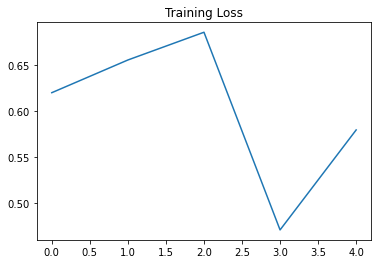

In [14]:
import matplotlib.pyplot as plt
plt.title('Training Loss')
losses = [np.mean(list(trn_history[i].meters['loss'].deque)) for i in range(len(trn_history))]
plt.plot(losses)

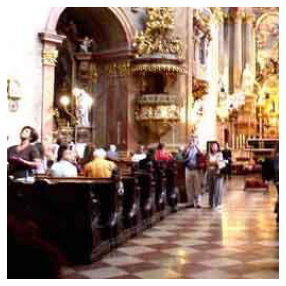

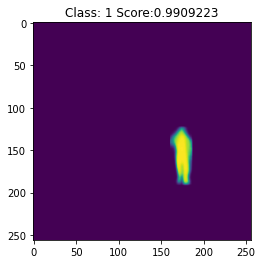

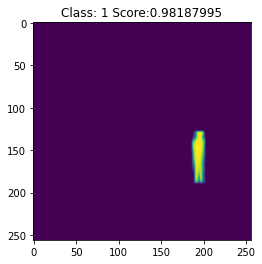

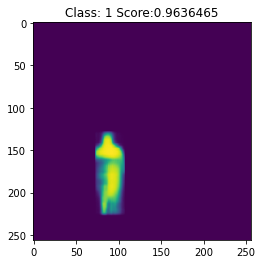

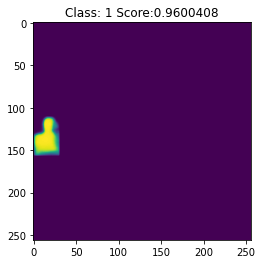

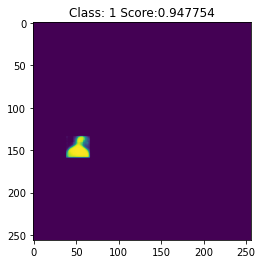

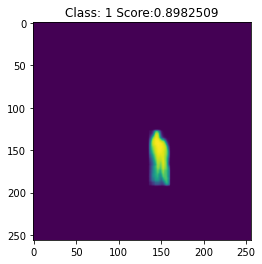

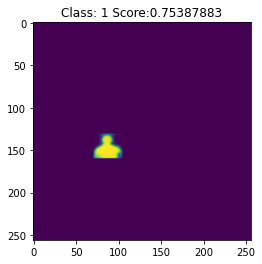

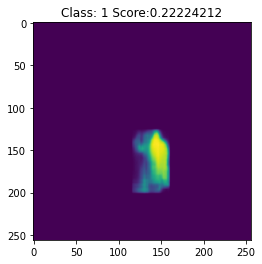

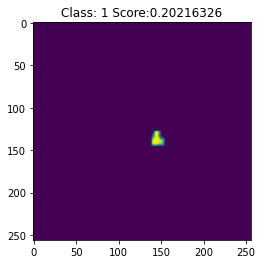

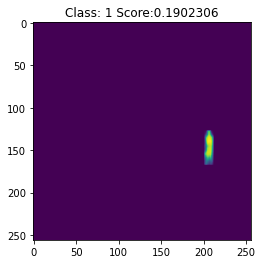

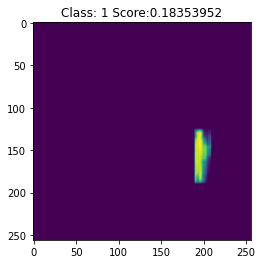

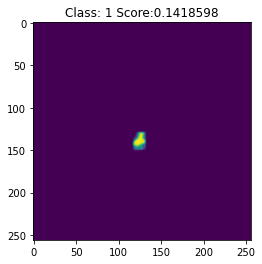

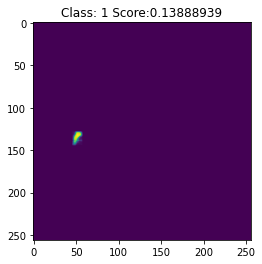

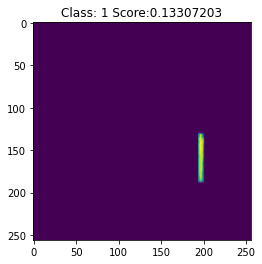

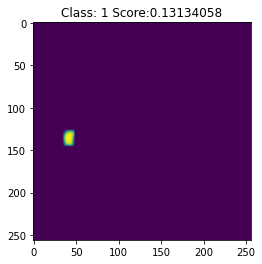

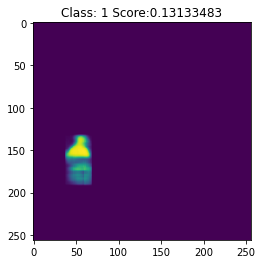

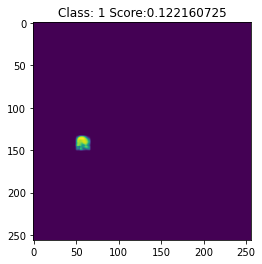

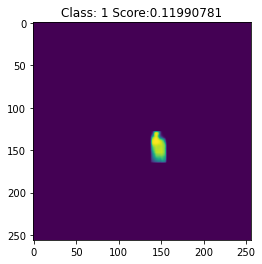

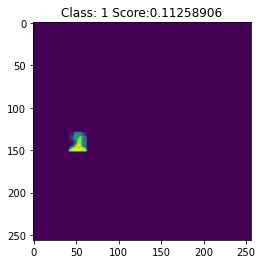

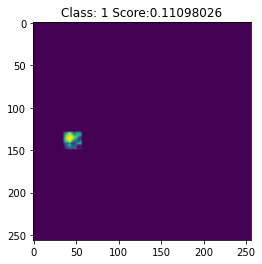

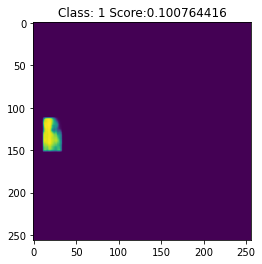

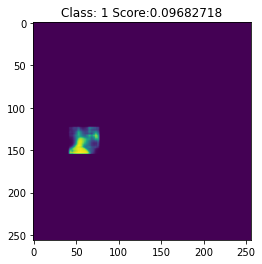

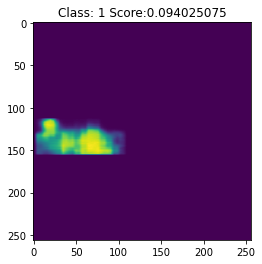

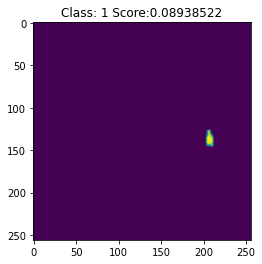

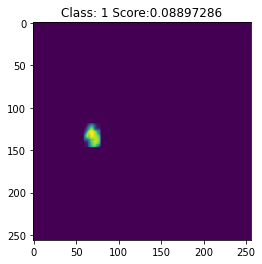

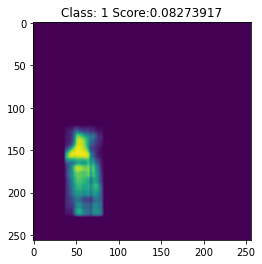

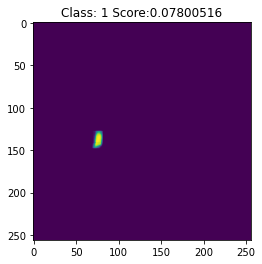

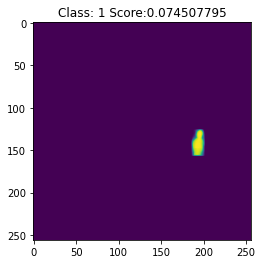

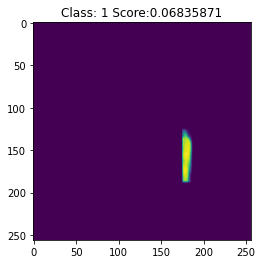

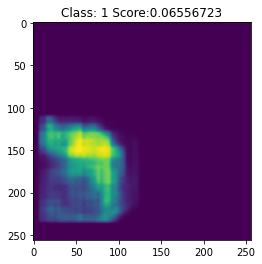

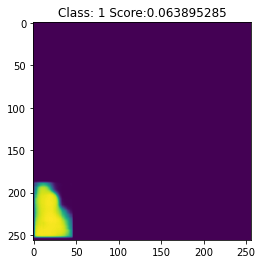

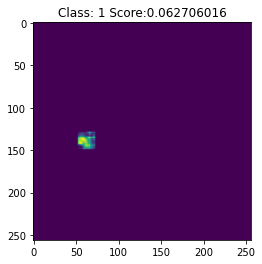

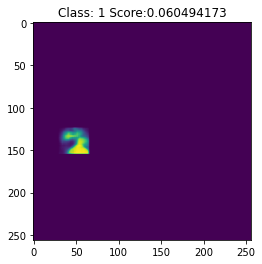

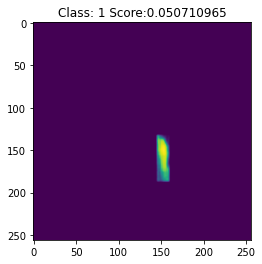

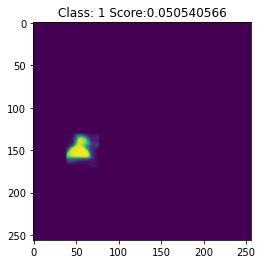

In [15]:
model.eval()
im = dataset_test[0][0]
show(im)
with torch.no_grad():
    prediction = model([im.to(device)])
    for i in range(len(prediction[0]['masks'])):
        plt.imshow(Image.fromarray(prediction[0]['masks'][i, 0].mul(255).byte().cpu().numpy()))
        plt.title('Class: '+str(prediction[0]['labels'][i].cpu().numpy())+' Score:'+str(prediction[0]['scores'][i].cpu().numpy()))
        plt.show()